## Non-Negative Matrix Factorization (NMF)

*Non-negative matrix factorization* is another unsupervised learning algorithm that aims to extract useful features. It works similarly to PCA and can also be used for dimensionality reduction. As in PCA, we are trying to write each data point as a weighted sum of some components. 

But whereas in PCA we wanted components that were orthogonal and that explained as much variance of the data as possible, in NMF, we want the components and the coefficients to be non-negative; that is, we want both the components and the coefficients to be greater than or equal to zero. Consequently, this method can only be applied to data where each feature is non-negative, as a non-negative sum of non-negative components cannot become negative.

The process of decomposing data into a non-negative weighted sum is particularly helpful for data that is created as the addition (or overlay) of several independent sources, such as an audio track of multiple people speaking, or music with many instruments. In these situations, NMF can identify the original components that make up the combined data. Overall, NMF leads to more interpretable components than PCA, as negative components and coefficients can lead to hard-to-interpret cancellation effects. 

The eigenfaces, for example, contain both positive and negative parts, and as we mentioned in the description of PCA, the sign is actually arbitrary. Before we apply NMF to the face dataset, let’s briefly revisit the synthetic data.

### Applying NMF To Synthetic Data

In contrast to when using PCA, we need to ensure that our data is positive for NMF to be able to operate on the data. This means where the data lies relative to the origin (0, 0) actually matters for NMF. Therefore, you can think of the non-negative components that are extracted as directions from (0, 0) toward the data.

The following example shows the results of NMF on the two-dimensional toy data.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

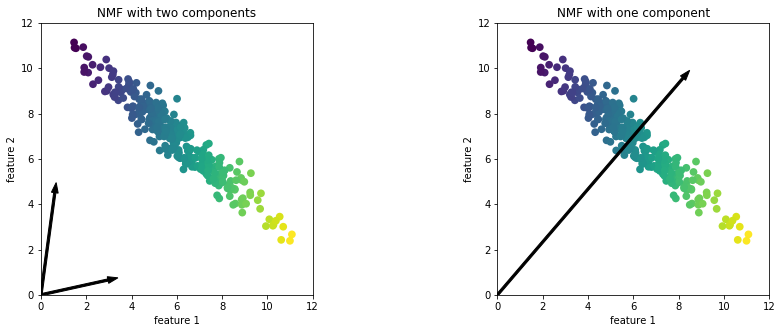

In [3]:
mglearn.plots.plot_nmf_illustration()

For NMF with two components, as shown on the left, it is clear that all points in the data can be written as a positive combination of the two components. If there are enough components to perfectly reconstruct the data (as many components as there are features), the algorithm will choose directions that point toward the extremes of the data.

If we only use a single component, NMF creates a component that points toward the mean, as pointing there best explains the data. You can see that in contrast with PCA, reducing the number of components not only removes some directions, but creates an entirely different set of components! Components in NMF are also not ordered in any specific way, so there is no “first non-negative component”: all components play an equal part.

NMF uses a random initialization, which might lead to different results depending on the random seed. In relatively simple cases such as the synthetic data with two components, where all the data can be explained perfectly, the randomness has little effect (though it might change the order or scale of the components). In more complex situations, there might be more drastic changes.

### Applying NMF To Face Images

Now, let’s apply NMF to the *Labeled Faces in the Wild* dataset we used earlier. The main parameter of NMF is how many components we want to extract. Usually this is lower than the number of input features (otherwise, the data could be explained by making each pixel a separate component).

First, let’s inspect how the number of components impacts how well the data can be reconstructed using NMF.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# Scale the grayscale values to be between 0 and 1
# Instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

________________________________________________________________________________
[Memory] Calling mglearn.plot_nmf.nmf_faces...
nmf_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))
_____________________________________________________nmf_faces - 696.9s, 11.6min


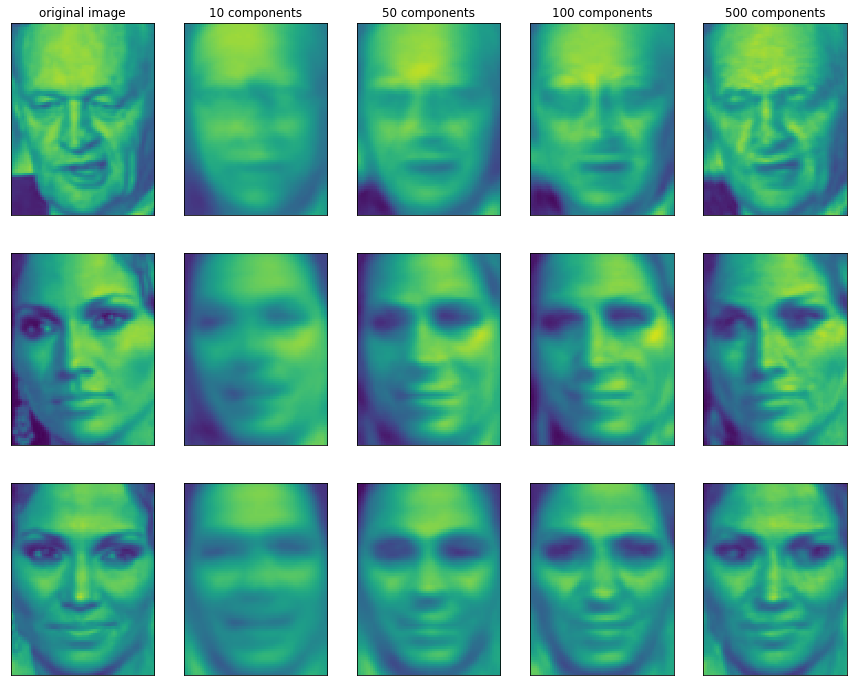

In [6]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

The quality of the back-transformed data is similar to when using PCA, but slightly worse. This is expected, as PCA finds the optimum directions in terms of reconstruction. NMF is usually not used for its ability to reconstruct or encode data, but rather for finding interesting patterns within the data. 

As a first look into the data, let’s try extracting only a few components (say, 15).

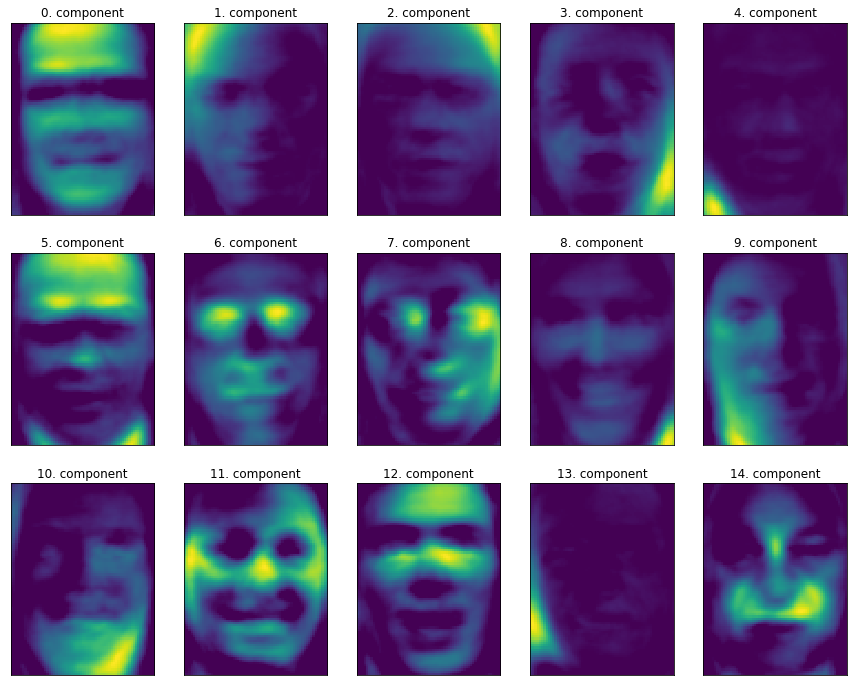

In [7]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

These components are all positive, and so resemble prototypes of faces much more so than the components shown for PCA. For example, one can clearly see that component 3 shows a face rotated somewhat to the right, while component 7 shows a face somewhat rotated to the left. 

Let’s look at the images for which these components are particularly strong.

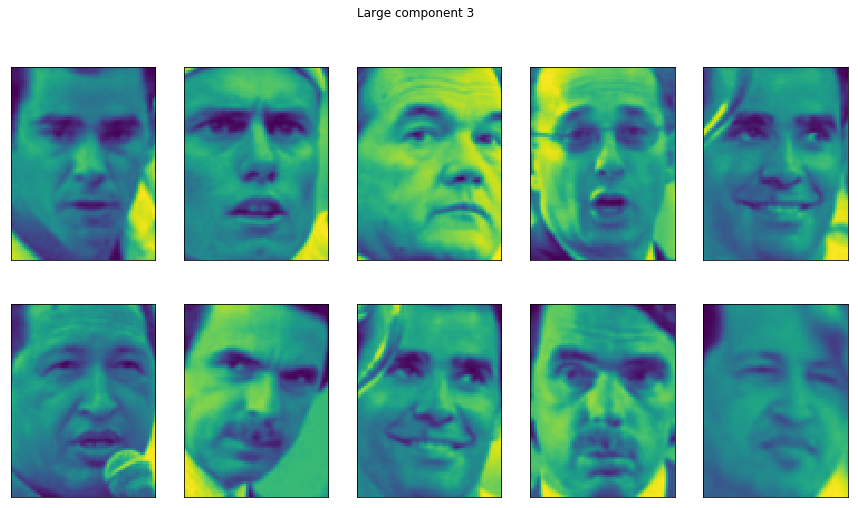

In [8]:
compn = 3
# Sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 3")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

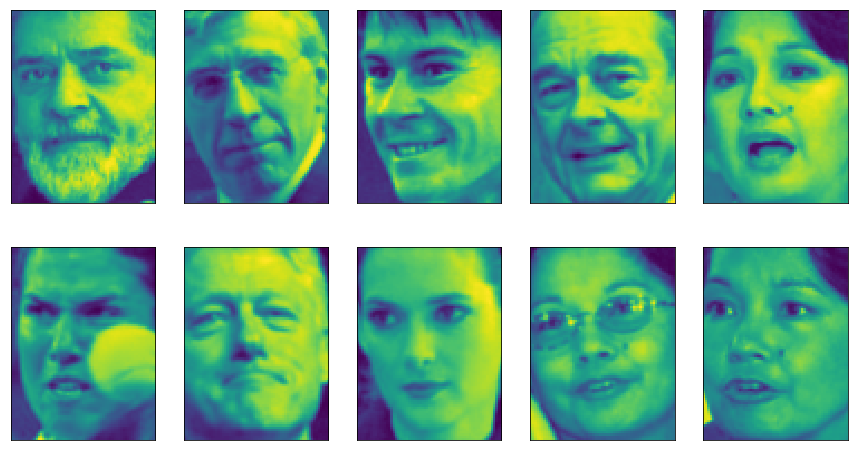

In [9]:
compn = 7
# Sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig.suptitle("Large component 7")
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

As expected, faces that have a high coefficient for component 3 are faces looking to the right, while faces with a high coefficient for component 7 are looking to the left. 

As mentioned earlier, extracting patterns like these works best for data with additive structure, including audio, gene expression, and text data. Let’s walk through one example on synthetic data to see what this might look like.

Let’s say we are interested in a signal that is a combination of three different sources.

Text(0, 0.5, 'Signal')

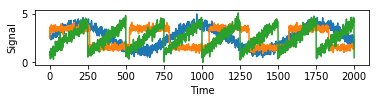

In [10]:
S = mglearn.datasets.make_signals()

plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

Unfortunately we cannot observe the original signals, but only an additive mixture of all three of them. We want to recover the decomposition of the mixed signal into the original components. We assume that we have many different ways to observe the mixture (say 100 measurement devices), each of which provides us with a series of measurements

In [12]:
# Mix data into a 100-dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)

print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


We can use NMF to recover the 3 signals:

In [14]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

Recovered signal shape: (2000, 3)


For comparison, we also apply PCA:

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X)

Now, we can plot the signal strength that was discovered by NMF and PCA.

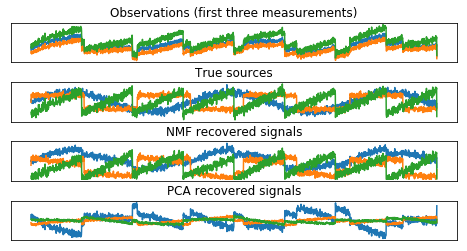

In [17]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

The figure includes 3 of the 100 measurements from the mixed measurements X for reference. As you can see, NMF did a reasonable job of discovering the original sources, while PCA failed and used the first component to explain the majority of the variation in the data. Keep in mind that the components produced by NMF have no natural ordering. In this example, the ordering of the NMF components is the same as in the original signal (see the shading of the three curves), but this is purely accidental.

There are many other algorithms that can be used to decompose each data point into a weighted sum of a fixed set of components, as PCA and NMF do. Discussing all of them is beyond the scope of this book, and describing the constraints made on the components and coefficients often involves probability theory. If you are interested in this kind of pattern extraction, we recommend that you study the sections of the scikit_learn user guide on independent component analysis (ICA), factor analysis (FA), and sparse coding (dictionary learning), all of which you can find on the page about decomposition methods.